In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from pathlib import Path

In [2]:
data_folder = Path("../DiarrheaExample/Vamb_output")

list(data_folder.glob("*"))



[WindowsPath('../DiarrheaExample/Vamb_output/clusters.tsv'),
 WindowsPath('../DiarrheaExample/Vamb_output/clusters.tsv.gz'),
 WindowsPath('../DiarrheaExample/Vamb_output/coverage.tsv'),
 WindowsPath('../DiarrheaExample/Vamb_output/latent.npz'),
 WindowsPath('../DiarrheaExample/Vamb_output/lengths.npz'),
 WindowsPath('../DiarrheaExample/Vamb_output/mask.npz'),
 WindowsPath('../DiarrheaExample/Vamb_output/tnf.npz')]

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load the data
latent_data = np.load(data_folder/'latent.npz')
clusters_data = pd.read_csv(data_folder/'clusters.tsv', sep='\t', header=None)
clusters_data.columns = ['cluster', 'id']

lengths_data = np.load(data_folder/'lengths.npz')


updated_clusters_data = pd.read_csv(data_folder/'clusters.tsv.gz', sep='\t', compression='gzip')
updated_clusters_data.columns = ['Sample', 'Contig', 'BinID', 'OriginalName', 'Large_enough']

# Concatenate 'Sample' and 'Contig' in the updated_clusters_data to align with the 'id' in clusters_data
updated_clusters_data['Sample_Contig'] = updated_clusters_data['Sample'] + ":" + updated_clusters_data['Contig']

# Create a dictionary that maps each 'Sample_Contig' in the updated data to a 'BinID'
updated_sample_contig_to_bin = pd.Series(updated_clusters_data.BinID.values, index=updated_clusters_data.Sample_Contig).to_dict()

# Add a new column to the original clusters data to hold the updated cluster assignments based on 'Sample_Contig'
clusters_data['updated_cluster'] = clusters_data['id'].map(updated_sample_contig_to_bin)





In [4]:
# stats

# Extract the sample name from the 'id' column in clusters_data
clusters_data['sample_name'] = clusters_data['id'].apply(lambda x: x.split(':')[0])
clusters_data['BinId'] = clusters_data['cluster'].apply(lambda x: x.split(':')[1])


# Add the lengths to the clusters_data DataFrame
clusters_data['length'] = lengths_data["arr_0"]

# Calculate the cumulative length of each cluster per sample
S = clusters_data.groupby(['sample_name', 'BinId'])['length'].sum().reset_index()

Text(0.5, 1.0, 'Maximum Bin size')

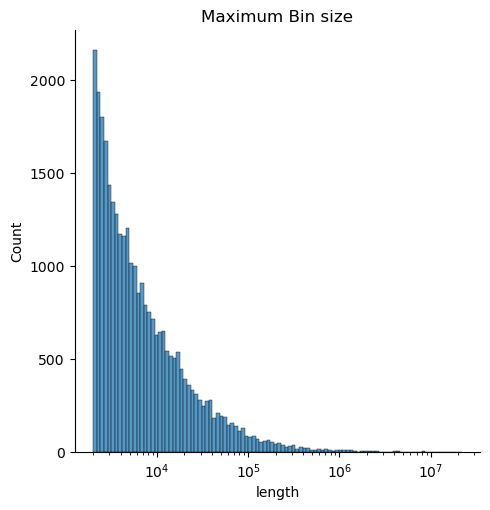

In [5]:
max_bin_length = S.groupby("BinId").length.max()
sns.displot(    x=max_bin_length,log_scale=True)
plt.title("Maximum Bin size")

In [6]:
S["Relative_length"] = S.length / max_bin_length.loc[S.BinId].values

Text(0.5, 1.0, "Number of Samples a 'bacterial genome' is found")

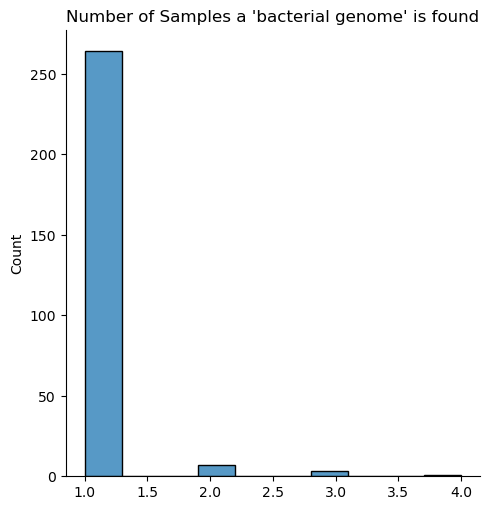

In [7]:
prevalence= S.query("length> 4e5 ").query("Relative_length>0.75").groupby("BinId").size() 
sns.displot(    x=prevalence)
plt.title("Number of Samples a 'bacterial genome' is found")

Text(0.5, 1.0, "Number of Samples a 'viral genome' is found")

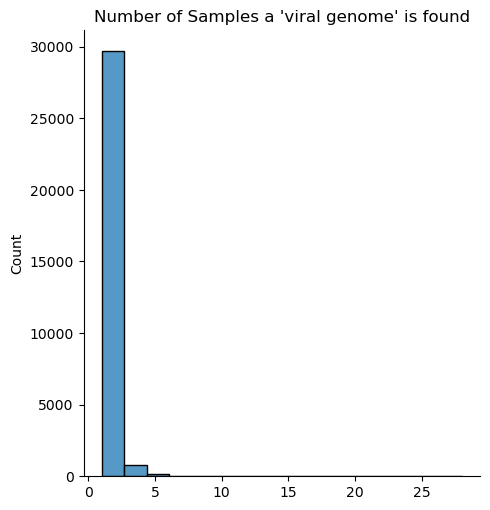

In [8]:
prevalence= S.query("length< 2e6 & length > 2e3 ").query("Relative_length>0.75").groupby("BinId").size() 
sns.displot(    x=prevalence)
plt.title("Number of Samples a 'viral genome' is found")

In [9]:
prevalence.sort_values()

BinId
1         1
27697     1
27696     1
27695     1
27694     1
         ..
867      19
289      20
1492     23
97       24
44       28
Length: 30695, dtype: int64

In [10]:
# load coverage info

coverage= pd.read_table(data_folder/"coverage.tsv", index_col=0)


In [11]:
bin_of_interest= 1000 # found only once
bin_of_interest= 126
all_contigs_of_bin =clusters_data.query("updated_cluster == @bin_of_interest")

In [20]:
contigs_of_interest = all_contigs_of_bin.id.unique()

In [24]:
S.query("BinId=='@bin_of_interest'")

,sample_name,BinId,length,Relative_length


In [25]:
max_bin_length.loc[str(bin_of_interest)] / 5e5

2.373224

<Axes: ylabel='contigName'>

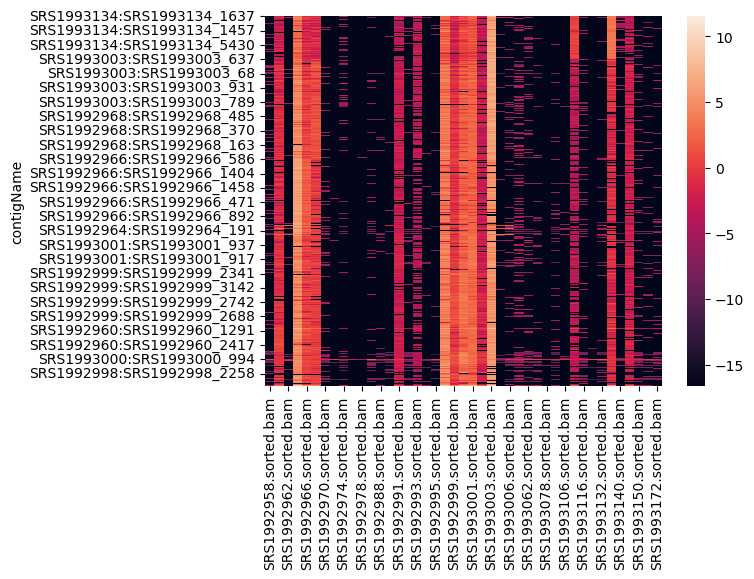

In [30]:
sns.heatmap(coverage.loc[contigs_of_interest].drop(["contigLen","totalAvgDepth"],axis=1).applymap(lambda x: np.log2(x+1e-5)) )

In [ ]:
# Perform PCA
pca = PCA(n_components=2)
reduced_data_pca = pca.fit_transform(latent_data['arr_0'])

# Filter out the non-clustered data points
filtered_pca_data = reduced_data_pca[clusters_data['updated_cluster'].notna()]
filtered_cluster_ids = clusters_data['updated_cluster'][clusters_data['updated_cluster'].notna()]

# Map the unique cluster IDs to new names (C1, C2, ...)
unique_cluster_ids = filtered_cluster_ids.unique()
new_cluster_names = ['C' + str(i+1) for i in range(len(unique_cluster_ids))]
cluster_id_to_name = dict(zip(unique_cluster_ids, new_cluster_names))

# Rename the cluster IDs in the filtered_cluster_ids Series
renamed_filtered_cluster_ids = filtered_cluster_ids.map(cluster_id_to_name)


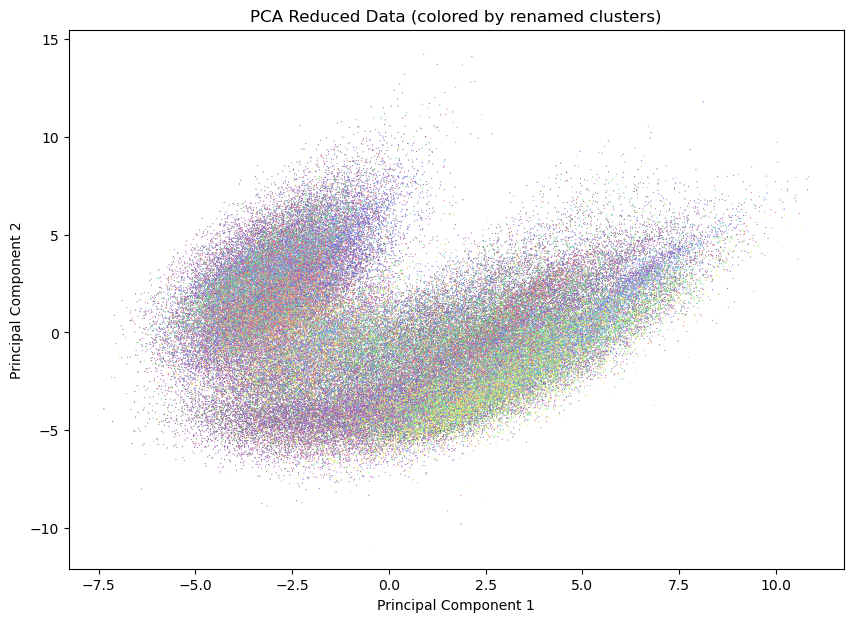

In [ ]:
# Plot the PCA-reduced data
plt.figure(figsize=(10, 7))
sns.scatterplot(x=filtered_pca_data[:, 0], y=filtered_pca_data[:, 1], hue=renamed_filtered_cluster_ids, s=2, marker='.', palette='nipy_spectral', legend=False)
plt.title("PCA Reduced Data (colored by renamed clusters)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

In [ ]:
import umap

# Perform UMAP
reducer = umap.UMAP()
reduced_data_umap = reducer.fit_transform(latent_data['arr_0'])

# Filter out the non-clustered data points for UMAP
filtered_umap_data = reduced_data_umap[clusters_data['updated_cluster'].notna()]



c:\Users\rdkiesersi1\AppData\Local\miniconda3\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\rdkiesersi1\AppData\Local\miniconda3\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\rdkiesersi1\AppData\Local\miniconda3\lib\site-packages\umap\d

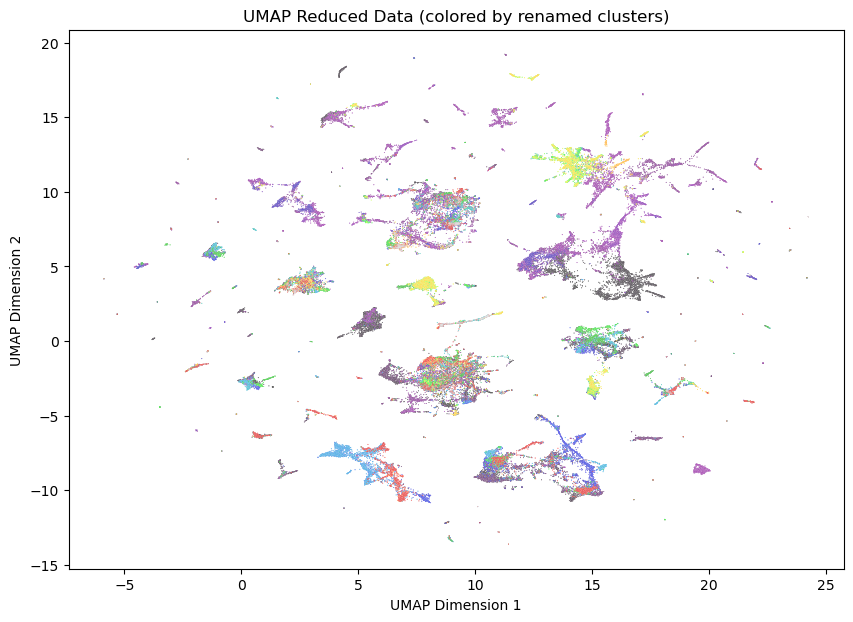

In [23]:
# Plot the UMAP-reduced data
plt.figure(figsize=(10, 7))
sns.scatterplot(x=filtered_umap_data[:, 0], y=filtered_umap_data[:, 1], hue=renamed_filtered_cluster_ids, s=2, marker='.', palette='nipy_spectral', legend=False)
plt.title("UMAP Reduced Data (colored by renamed clusters)")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()


0             C1
1             C2
2             C3
3             C4
4             C5
           ...  
112643    C30763
112644    C30764
112645    C30765
112646    C30766
112647    C30767
Name: updated_cluster, Length: 112648, dtype: object